In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
plt.style.use('ggplot')

In [2]:
df = pd.read_excel('./2210-v1.xlsx')
df.head()

Timestamp (YYYY-MM-DDThh:mm:ss)  Glucose Value (mg/dL)  \
0             2023-04-18T00:01:08                    155   
1             2023-04-18T00:06:09                    154   
2             2023-04-18T00:11:08                    152   
3             2023-04-18T00:16:08                    150   
4             2023-04-18T00:21:08                    146   

                food consumed  Time of food consumption  
0                         NaN                       NaN  
1                         NaN                       NaN  
2                         NaN                       NaN  
3                   Emergen C                       NaN  
4  Coffee with milk and honey                       NaN

In [3]:
glucose = df['Glucose Value (mg/dL)'].values
timestamp = df['Timestamp (YYYY-MM-DDThh:mm:ss)'].values
# partitions = np.linspace(0, len(df), 4).astype(np.int32)
partitions = [0, 3121, 5940, 8562]
food_timesteps = df['food consumed']
food_timesteps = food_timesteps[~pd.isna(food_timesteps)].index

df1, df2, df3 = df[partitions[0]:partitions[1]], df[partitions[1]:partitions[2]], df[partitions[2]:partitions[3]]
df.shape


(8652, 4)

In [4]:
dataset = {}

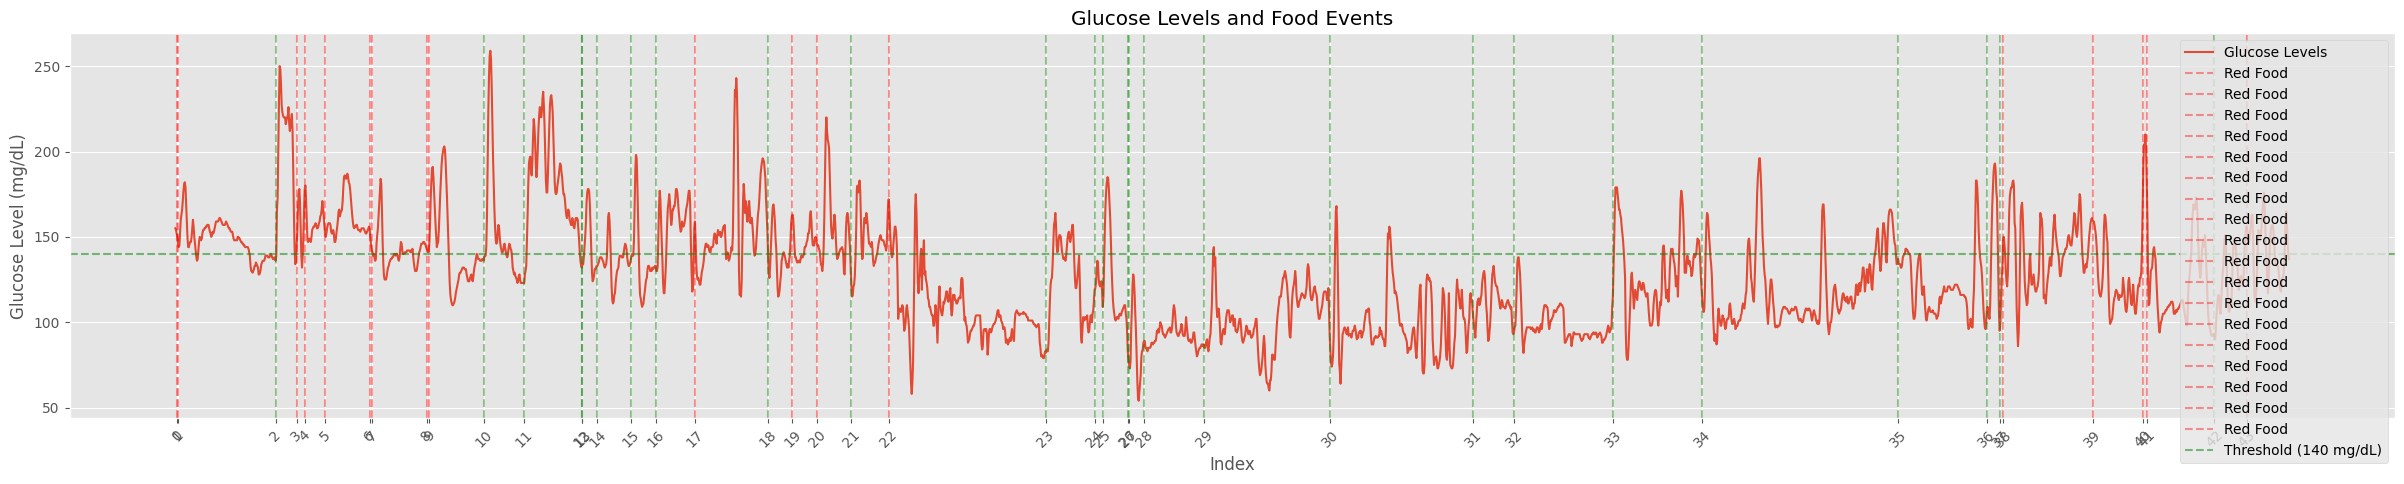

In [5]:
glucose = df1['Glucose Value (mg/dL)'].values
food_consumed = df1['food consumed'].fillna(0).values
food_timesteps1 = df1['food consumed']
food_timesteps1 = food_timesteps1[~pd.isna(food_timesteps1)].index

# Create dictionaries for red and green foods
red_foods = {}
green_foods = {}

# Classify foods based on glucose levels
for i, timestep in enumerate(food_timesteps1):
    if glucose[timestep] > 140:
        red_foods[i] = food_consumed[timestep]
    else:
        green_foods[i] = food_consumed[timestep]

# Plot the glucose levels with meal markers
plt.figure(figsize=(30, 5))
plt.plot(glucose, label="Glucose Levels")
for i in food_timesteps1:
    plt.axvline(i, color='r' if glucose[i] > 140 else 'g', linestyle='--', alpha=0.4,
                label="Red Food" if glucose[i] > 140 else "Green Food" if i == food_timesteps1[0] else "")
plt.axhline(140, color='g', linestyle='--', alpha=0.5, label="Threshold (140 mg/dL)")
plt.xticks(food_timesteps1, np.arange(len(food_timesteps1)), rotation=45)
plt.legend()
plt.title("Glucose Levels and Food Events")
plt.xlabel("Index")
plt.ylabel("Glucose Level (mg/dL)")
plt.show()

# Print red and green foods
print("Red Foods (Glucose > 140):")
for idx, food in red_foods.items():
    print(f"{idx} : {food}")

print("\nGreen Foods (Glucose <= 140):")
for idx, food in green_foods.items():
    print(f"{idx} : {food}")


In [6]:
food_timesteps1_new = np.insert(food_timesteps1, len(food_timesteps1), len(glucose) - 1)
food_timesteps1_diff = np.diff(food_timesteps1_new)
scores1 = []
for i in range(0, len(food_timesteps1_diff)):
    scores1.append(np.mean(np.abs(glucose[food_timesteps1_new[i]:food_timesteps1_new[i+1]] - 140)))


In [7]:
glucose.shape

Red Foods (Glucose > 140):
0 : Emergen C
1 : Coffee with milk and honey
3 : small size toast
4 : Grits Soup with Vegetables, Rice with chicken , onion salad 
5 : Peanuts , chocolate covered raisins
6 : Emergen C
7 : Coffee with milk and honey
8 : Probiotic Strawberry yogurt
9 : Fried plantains and egg, Coffee with milk and honey, water
17 : Soda , water
19 : banana
20 : water, bread , chicken, cofffe with milk and honey , grapes
22 : fried chicken, potatoes, salad, water
38 : pineapple
39 : Emergen C, Coffee with milk and honey
40 : banana,tangerine
41 : Coffee with milk and honey,grapes
43 : Coffee with milk and honey,bread , butter

Green Foods (Glucose <= 140):
2 : glucose drink
10 : Lomo Saltado()
11 : Fried rice , daily multivitamin and joint supplement, corn drink
12 : Emenrgen C
13 : Coffee with milk and honey
14 : Probiotic Strawberry yogurt, water
15 : Coffee with milk and honey
16 : Pizza
18 : Emergen C, Coffee with milk and honey
21 : water, pop corn , mineral water , Tanger

(3121,)

In [8]:
for i, timestep in enumerate(food_timesteps1):
    if food_consumed[timestep] not in dataset.keys():
        dataset[food_consumed[timestep]] = [scores1[i]]
    else:
        dataset[food_consumed[timestep]].append(scores1[i])

In [9]:
dataset

{'Emergen C': [10.0, 7.5],
 'Coffee with milk and honey': [10.972222222222221,
  6.675,
  16.136363636363637,
  17.62162162162162,
  53.869565217391305],
 'glucose drink': [63.516129032258064],
 'small size toast': [17.416666666666668],
 'Grits Soup with Vegetables, Rice with chicken , onion salad ': [18.333333333333332],
 'Peanuts , chocolate covered raisins': [20.939393939393938],
 'Probiotic Strawberry yogurt': [1.75],
 'Fried plantains and egg, Coffee with milk and honey, water': [20.475],
 'Lomo Saltado()': [21.7],
 'Fried rice , daily multivitamin and joint supplement, corn drink': [44.49411764705882],
 'Emenrgen C': [8.0],
 'Probiotic Strawberry yogurt, water': [8.653061224489797],
 'Pizza': [21.43103448275862],
 'Soda , water': [20.50925925925926],
 'Emergen C, Coffee with milk and honey': [11.194444444444445,
  41.95205479452055,
  27.006920415224915,
  22.46564885496183,
  22.04054054054054],
 'banana': [8.027777777777779],
 'water, bread , chicken, cofffe with milk and honey

### Observation
Based on the above plots and some extra searching on the interenet, we can observe that:

The following can be classified as potential Red Foods:

1. Sugary Drinks and Added Sugars:

    - Emergen C (Items 0, 6, 12, 18, 26, 32, 34, 35, 39): Contains sugar and added vitamins, potentially spiking glucose.
    - Coffee with milk and honey (Items 1, 7, 9, 13, 15, 27, 28, 29, 30, 36, 41, 43): The milk and honey add sugar.
    - Corn drink (Items 11, 23, 24): Often sweetened and sugary.

2. Refined Carbs:

    - Toast (Item 3): Made from refined white bread, which can spike glucose.
    - Bread (Items 20, 23, 43): Refined flour products raise blood sugar levels.
    - Fried potatoes (Items 22, 23, 24): Fried potatoes are high in simple carbohydrates, especially when deep-fried.
    - Sub sandwich with pork (Items 29, 30): Sandwich bread is made from refined flour.

3. Carb-Dense Meals:

    - Fried rice (Item 11): White rice, a refined carb, can cause glucose spikes.
    - Rice with chicken (Item 4): White rice spikes glucose, though the protein from chicken helps stabilize it.
    - Rice, eggs (Item 28): Like above, rice can spike glucose, especially if it's white rice.

4. Sweetened Dairy and Processed Snacks:

    - Probiotic strawberry yogurt (Items 8, 14): Depending on the sugar content, sweetened yogurts can cause glucose spikes.
    - Chocolate-covered raisins (Item 5): High sugar content.
    - Glucose drink

The following can be classified as non-red foods and potential green food:

1. Whole Foods with Low Glycemic Index:

    - Peanuts (Item 5): High in healthy fats and protein, low glycemic impact.
    - Tangerines (Items 21, 40): Fruit with a relatively low glycemic index.
    - Pineapple (Item 38): Although slightly higher in GI than some fruits, it's still a better option than refined carbs.
    - Broccoli (Item 33): Low glycemic index and high in fiber.
    - Salad (Items 22, 24): Usually made from vegetables with minimal impact on blood sugar.
    - Carrots, beets, peas (Item 42): These vegetables, while starchy, have lower glycemic impacts when consumed in moderation.

2. Lean Protein:

    - Chicken (Items 4, 20, 22, 23, 33, 37, 42): Lean proteins like chicken have minimal impact on glucose levels.
    - Pork (Items 29, 30): Similar to chicken, lean pork doesn't significantly affect glucose.
    - Oven-baked chicken (Item 31): This is a lean protein with a low glycemic impact.

3. Whole Grains and Vegetables:

    - Sweet potato (Item 29): A whole food with a moderate glycemic index, but still healthier than refined carbs.
    - Onion salad (Items 4, 20, 29, 30): Onions are low in carbs and have minimal glycemic impact.
    - Potatoes (Item 42): While they have a high glycemic index, they're better when consumed in whole, non-fried forms.




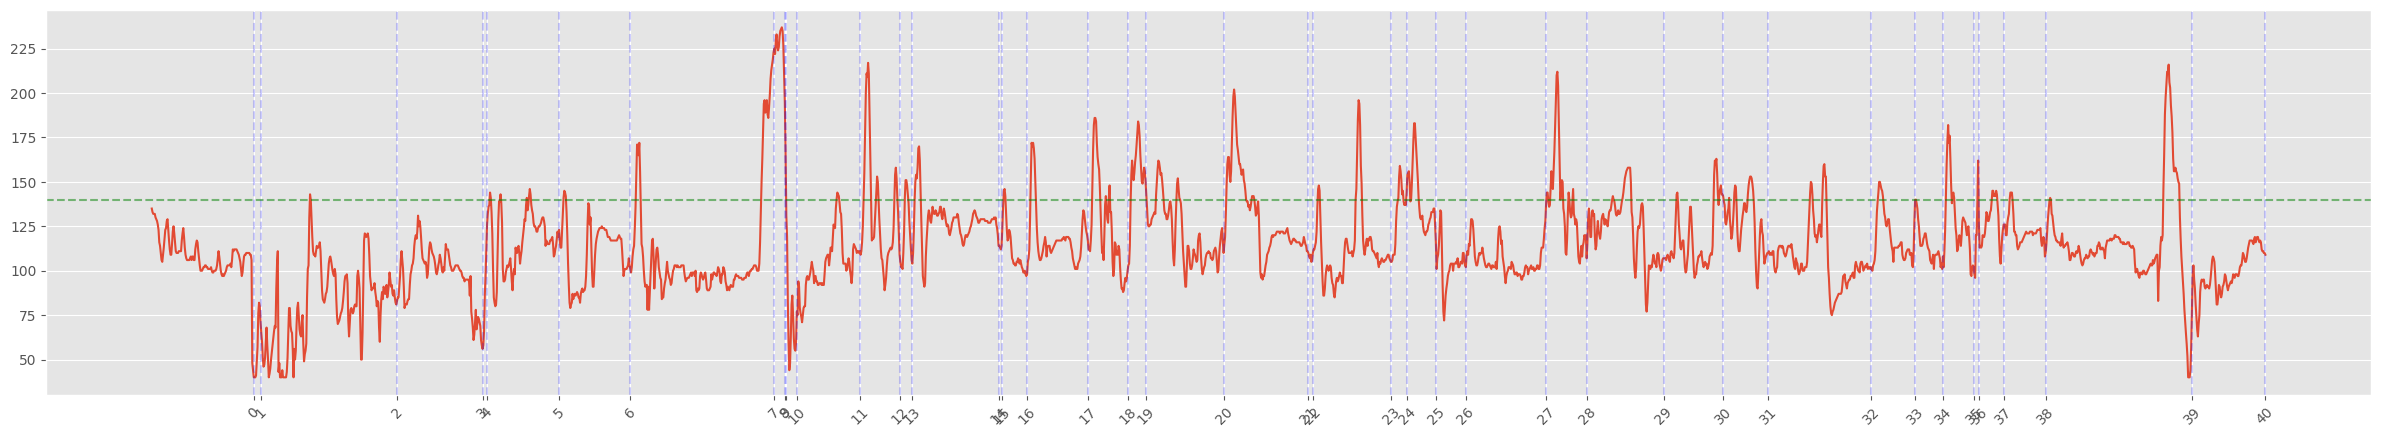

0 : Glucose test
1 : rice , pork, pork bun , tea
2 : banana
3 : rice, pork chop, water , orange juice
4 : salad , pop corn, coffe with milk and honey, marshmallows, water
5 : emergen C , coffee with milk and honey
6 : egg, plantains, bread, water
7 : probiotic strawberry yogurt , water
8 : vitamin c
9 : coffee with milk and honey
10 : banana
11 : rice, tilapia , apple , coffe with milk and honey
12 : pizza
13 : tilapia, salad
14 : Emergen C, Coffee with milk
15 : allergy pills 
16 : banana, blueberries, grapes,water
17 : donut,coffee with milk and stevia,cup cake, raspberries,grapes
18 : oven baked chicken, rice,salad, water
19 : pop corn, raisins, peanuts,water,coffee with milk
20 : rice , vegetables,salad, water
21 : bagel
22 : coffee with milk , egg
23 : pop corn, raisins, peanuts,water.
24 : chicken,potatoes,salad, water
25 : coffee with milk 
26 : banana, blueberries,strawberry,raspberries, water, pop corn
27 : lomo salatado,rice, potatoes, onions
28 : pizza, water
29 : coffee wit

In [10]:

glucose2 = df2['Glucose Value (mg/dL)'].values
food_consumed2 = df2['food consumed'].fillna(0).values
food_timesteps2 = df2['food consumed']
food_timesteps2 = food_timesteps2[~pd.isna(food_timesteps2)].index - partitions[1]


plt.figure(figsize=(30, 5))
plt.plot(glucose2)
for i in food_timesteps2:
    plt.axvline(i, color='b', linestyle='--', alpha=0.2)
plt.axhline(140, color='g', linestyle='--', alpha=0.5)
plt.xticks(food_timesteps2, np.arange(len(food_timesteps2)), rotation=45)

plt.show()
for i, timestep in enumerate(food_timesteps2):
    print(f"{i} : {food_consumed2[timestep]}")

In [11]:
food_timesteps2_new = np.insert(food_timesteps2,  len(food_timesteps2), len(glucose2) - 1)
food_timesteps2_diff = np.diff(food_timesteps2_new)
scores2 = []
for i in range(0, len(food_timesteps2_diff)):
    scores2.append(np.mean(np.abs(glucose2[food_timesteps2_new[i]:food_timesteps2_new[i+1]] - 140)))


for i, timestep in enumerate(food_timesteps2):
    if food_consumed2[timestep] not in dataset.keys():
        dataset[food_consumed2[timestep]] = [scores2[i]]
    else:
        dataset[food_consumed2[timestep]].append(scores2[i])

### Observation

The following can be classified as potential Red Foods:

1. Sugary Drinks and Added Sugars:

    - Emergen C (Items 5, 8, 14, 38): Contains sugar and added vitamins, which can spike glucose levels.
    - Coffee with milk and honey (Items 1, 9, 17, 19, 22, 25, 29, 40): The milk and honey add sugar, which can cause glucose spikes.
    - Orange juice (Items 3, 37): High in natural sugars with a high glycemic index, leading to glucose spikes.
    - Marshmallows (Item 4): Contains sugar, which can spike glucose levels.

2. Refined Carbs:

    - Rice (Items 1, 3, 11, 18, 20, 27, 30, 39): White rice is a refined carbohydrate that can cause glucose spikes.
    - Bread (Item 6): White bread is a refined carb, leading to a faster glucose spike.
    - Bagel (Item 21): Made from refined flour, which can cause glucose spikes.
    - Popcorn (Items 4, 19, 23, 26, 36): While it has a relatively low glycemic index, when consumed in large amounts, it can still cause some glucose spikes, especially when salted or processed.
    - Donut, cupcake (Item 17): High in sugar and refined flour, leading to glucose spikes.

3. Processed Snacks:

    - Raisins (Items 19, 23, 26): Dried fruits like raisins are high in sugar and can spike glucose.
    - Peanuts (Items 19, 23, 39): Though peanuts are low in glycemic index, they can still lead to a moderate glucose increase when consumed with sugar-laden foods (like in popcorn or raisins).

4. Sweetened Dairy and Processed Foods:

    - Probiotic strawberry yogurt (Items 7, 33): Contains sugar and could cause glucose spikes, especially if it's flavored.
    - Cupcake (Item 17): High in sugar and refined flour, contributing to glucose spikes.
    - Pizza (Items 12, 28): Typically made with refined flour crust and high-carb toppings, which can cause glucose spikes.

===============================================================================

The following can be classified as non-red foods and potential green foods:

1. Fruits:
    - Banana (Items 2, 10, 16, 26, 37): Bananas have a moderate glycemic index but are rich in fiber, potassium, and vitamins.
    - Blueberries, strawberries, raspberries (Items 16, 17, 29, 30, 37): Berries are lower in sugar and have a lower glycemic index.
    - Apple (Item 11): Has a moderate glycemic index, but it's rich in fiber, which helps stabilize glucose levels.
    - Tangerines (Item 31): A relatively low glycemic fruit.
    
2. Lean Proteins and Vegetables:

    - Chicken (Items 18, 24, 39): A lean protein that has minimal impact on glucose levels.
    - Eggs (Items 6, 22, 37): Low glycemic index and high in protein, which helps stabilize glucose.
    - Broccoli (Items 30, 37): A non-starchy vegetable that is low in carbohydrates and fiber-rich.
    - Lentils (Items 34, 35): A legume with a low glycemic index and high fiber content.
    - Celery (Item 31): A very low glycemic food that has little to no impact on glucose levels.

3. Whole Grains and Starches:
    
    - Potatoes (Items 24, 27, 31): When not fried, potatoes are a starchy food but their glycemic impact is moderated when consumed with protein or fat.



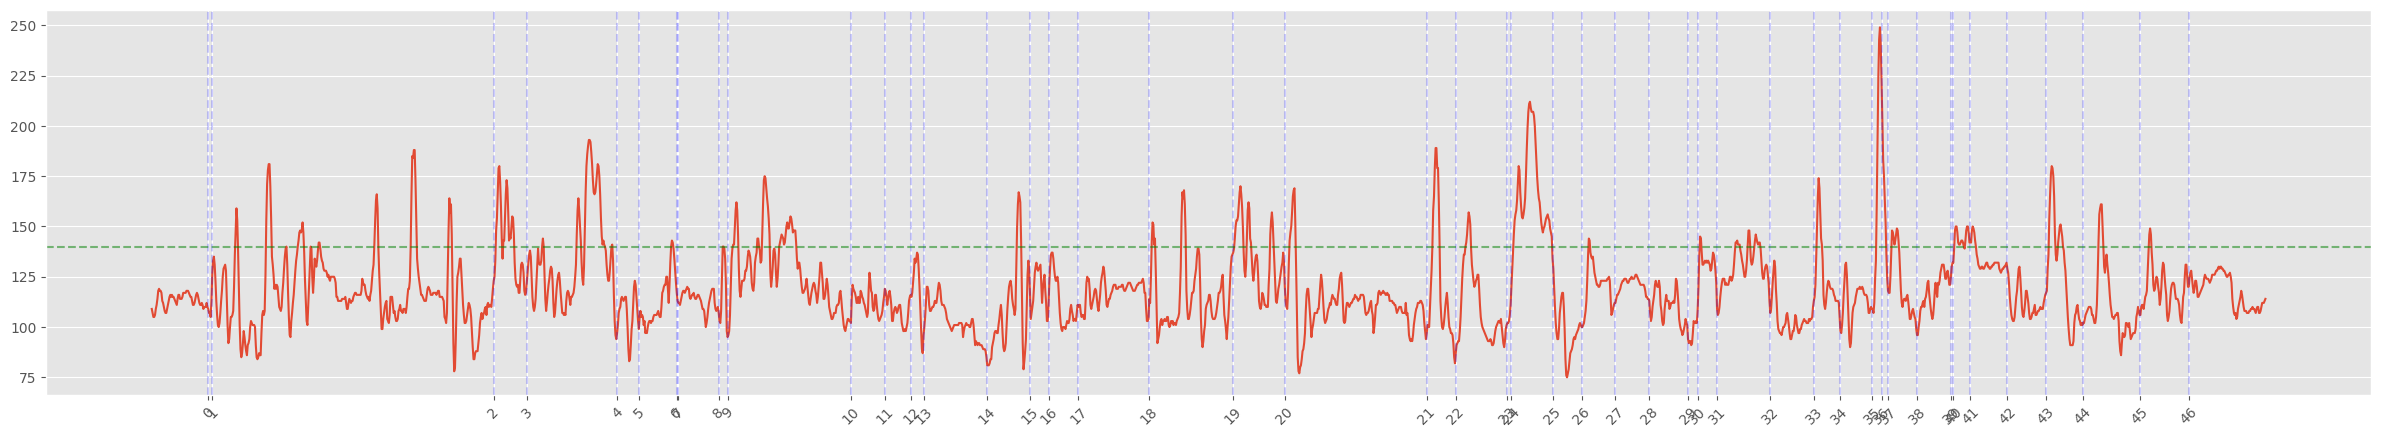

0 : emergen c , coffee with milk
1 : probiotic strawberry yogurt
2 : fried noodles , beef , blueberries, grapes, strawberries
3 : tilapia,rice, salad, water
4 : emergen c , coffee with milk
5 : banana, blueberries,grapes
6 : pineapple
7 : peanuts
8 : pineapple, buffallo wings,plantains,eggs, bacon
9 : probiotic strawberry yogurt
10 : grapes , blueberries
11 : bread, chicken , coffee with milk
12 : bread,chicken
13 : pop corn,water
14 : guava, bacon, egg,huanciana sauce 
15 : rice ,pinto beans, beef,huanciana sauce 
16 : peanuts , raisins
17 : banana, water
18 : vitamin c, coffee with milk, banana
19 : brocolli, lettuce, tomato,steak
20 : vitamin c, coffee with milk
21 : apple pie
22 : rice, pinto beans, beef
23 : tart cake,bread,eggs
24 : orange juice
25 : vitamin c, coffee with milk
26 : banana
27 : peanuts
28 : blueberry,strawberry,raspberries
29 : fish,onions
30 : rice,potatoes,chicken
31 : peanuts,raisins
32 : vitamin c, coffee with milk
33 : blueberry,strawberry,raspberries
34 : c

In [12]:

glucose3 = df3['Glucose Value (mg/dL)'].values
food_consumed3 = df3['food consumed'].fillna(0).values
food_timesteps3 = df3['food consumed']
food_timesteps3 = food_timesteps3[~pd.isna(food_timesteps3)].index - partitions[2]


plt.figure(figsize=(30, 5))
plt.plot(glucose3)
for i in food_timesteps3:
    plt.axvline(i, color='b', linestyle='--', alpha=0.2)
plt.axhline(140, color='g', linestyle='--', alpha=0.5)
plt.xticks(food_timesteps3, np.arange(len(food_timesteps3)), rotation=45)

plt.show()
for i, timestep in enumerate(food_timesteps3):
    print(f"{i} : {food_consumed3[timestep]}")

In [13]:
food_timesteps3_new = np.insert(food_timesteps3, len(food_timesteps3), len(glucose3) - 1)
food_timesteps3_diff = np.diff(food_timesteps3_new)
scores3 = []
for i in range(0, len(food_timesteps3_diff)):
    scores3.append(np.mean(np.abs(glucose3[food_timesteps3_new[i]:food_timesteps3_new[i+1]] - 140)))


for i, timestep in enumerate(food_timesteps3):
    if food_consumed3[timestep] not in dataset.keys():
        dataset[food_consumed3[timestep]] = [scores3[i]]
    else:
        dataset[food_consumed3[timestep]].append(scores3[i])

### Observation
The following can be classified as potential red-foods:

1. Sugary Drinks and Added Sugars:

    - Emergen C (Items 0, 4, 18, 25, 32, 42): Contains sugar and added vitamins, which can spike glucose levels.
    - Coffee with milk (Items 0, 4, 11, 18, 20, 25, 34, 42, 44): The milk and any added sugar (if used) can cause glucose spikes.
    - Orange juice (Item 24): High in natural sugars, leading to rapid glucose spikes.
    - Apple pie (Item 21): High in sugar and refined carbs, causing glucose spikes.
    - Tart cake, bread, eggs (Item 23): Contains sugar and refined flour, which can cause glucose spikes.
    - Condensed milk (Item 36): Contains high amounts of sugar, which can significantly increase blood sugar.

2. Refined Carbs and Processed Foods:

    - Bread (Items 11, 12, 13, 23, 36, 44): Refined carbs that can cause glucose spikes.
    - Rice (Items 3, 15, 22, 30, 38): White rice is a refined carbohydrate that can lead to glucose spikes.
    - Popcorn (Item 13): While it is a whole grain, when consumed in large amounts or with added sugar, it can cause glucose spikes.
    - Plantains (Items 8, 34): Plantains are starchy and can raise glucose, especially if fried.
    - Tart cake, bread, eggs (Item 23): Contains refined carbs and sugar, leading to glucose spikes.

3. Dried Fruits and High-Sugar Snacks:

    - Peanuts and raisins (Items 7, 16, 27, 31): Peanuts are okay in moderation, but raisins are high in sugar and can raise glucose.
    - Bananas (Items 5, 17, 18, 26, 43): Bananas have a moderate glycemic index, so they can cause moderate glucose spikes, particularly when consumed in large quantities.
    - Grapes (Items 5, 10, 35): Grapes are relatively high in sugar, which can spike glucose.
    - Pineapple (Items 6, 8): Pineapple is high in sugar and has a relatively high glycemic index, which can lead to glucose spikes.


### Conclusion

#### Common Red Foods:
1. **Sugary Drinks and Added Sugars**: Coffee with milk and honey, Orange juice, Emergen C

2. **Refined Carbs**: White bread, White rice, Bagels, Popcorn

3. **Processed Snacks**: Raisins Peanuts (when consumed with sugar-laden foods)

4. **Sweetened Dairy and Processed Foods**: Probiotic strawberry yogurt Cupcake Pizza

#### Common Green Foods:
1. **Fruits**: Blueberries, strawberries, raspberries Tangerines

2. **Lean Proteins and Vegetables**: Chicken Eggs Broccoli Lentils Celery

3. **Whole Grains and Starches**: Potatoes (not fried) Sweet potatoes

In [14]:
dataset_final = {}

for k, v in dataset.items():
    score = np.mean(v)
    if score != 0:
        dataset_final[k] = np.mean(v)

dataset_final

{'Emergen C': 8.75,
 'Coffee with milk and honey': 21.05495453951976,
 'glucose drink': 63.516129032258064,
 'small size toast': 17.416666666666668,
 'Grits Soup with Vegetables, Rice with chicken , onion salad ': 18.333333333333332,
 'Peanuts , chocolate covered raisins': 20.939393939393938,
 'Probiotic Strawberry yogurt': 1.75,
 'Fried plantains and egg, Coffee with milk and honey, water': 20.475,
 'Lomo Saltado()': 21.7,
 'Fried rice , daily multivitamin and joint supplement, corn drink': 44.49411764705882,
 'Emenrgen C': 8.0,
 'Probiotic Strawberry yogurt, water': 8.653061224489797,
 'Pizza': 21.43103448275862,
 'Soda , water': 20.50925925925926,
 'Emergen C, Coffee with milk and honey': 24.931921809938455,
 'banana': 26.642596073517126,
 'water, bread , chicken, cofffe with milk and honey , grapes': 17.784313725490197,
 'water, pop corn , mineral water , Tangerines': 13.363636363636363,
 'fried chicken, potatoes, salad, water': 35.456896551724135,
 'bread , grapes, chicken, fried 

In [15]:
X, y = [], []

def clean(text):
    import re
    return re.sub(r'[^\w\s]', '', text).strip().lower()

for k, v in dataset_final.items():
    # food = " ".join([clean(food).strip() for food in k.split(',')])
    # X.append([f for f in food.split(' ')])
    X.append(' '.join(clean(k).split()))
    y.append(v)

X


['emergen c',
 'coffee with milk and honey',
 'glucose drink',
 'small size toast',
 'grits soup with vegetables rice with chicken onion salad',
 'peanuts chocolate covered raisins',
 'probiotic strawberry yogurt',
 'fried plantains and egg coffee with milk and honey water',
 'lomo saltado',
 'fried rice daily multivitamin and joint supplement corn drink',
 'emenrgen c',
 'probiotic strawberry yogurt water',
 'pizza',
 'soda water',
 'emergen c coffee with milk and honey',
 'banana',
 'water bread chicken cofffe with milk and honey grapes',
 'water pop corn mineral water tangerines',
 'fried chicken potatoes salad water',
 'bread grapes chicken fried potatoes corn drink',
 'salad fried chicken corn drink',
 'multivitamin joint supplementallergy pills',
 'vitamin c',
 'rice eggs coffe with milk and honey tangerine',
 'coffee with milk and honeysub sandwichpork sweet potato onion salad',
 'coffee with milk and honeysub sandwichpork bread condensed milk',
 'oven baked chicken',
 'brocolli

In [16]:
# TF-IDF on the X: used to convert text data into numerical data based on term frequencey and inverse document frequency
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X).toarray()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR


y_scaled = StandardScaler().fit_transform(np.array(y).reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_scaled, test_size=0.2, random_state=42)

random_forest = RandomForestRegressor(n_estimators=50, random_state=42)
gboosting = GradientBoostingRegressor(n_estimators=50, random_state=42)
linear_reg = LinearRegression()
svr = SVR(kernel='poly', degree=3)

models = {
    'Random Forest': random_forest,
    'Support Vector Regression': svr,
    'Linear Regression': linear_reg
}

for model in models:
    models[model].fit(X_train, y_train)
    pred = models[model].predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{model} : mse={mse:.3f}, r2={r2:.2f}")



Random Forest : mse=1.252, r2=-0.51
Support Vector Regression : mse=0.770, r2=0.07
Linear Regression : mse=831250030956801402339328.000, r2=-999732566302395306344448.00
